# Deep Learning for Natural Language Processing

## Recap Neural Networks

## CNN (Convolutional Neural Networks)

Rețelele neuronale convoluționale constau în principal dintr-o secvență de „straturi convoluționale”, urmate de straturi dense (straturi de rețele neuronale artificiale).

Un strat convoluțional poate consta din:
  - [Convoluții](https://ezyang.github.io/convolution-visualizer/)
  - Funcția de activare (ReLU, LeakyReLU, GELU, Swiss, etc.)
  - Pooling (max, min, mediu etc.)
  - Batch Normalization (metodă pentru îmbunătățirea eficienței învățării)

Convoluțiile sunt folosite pentru a exploata forma 2D a unei imagini. În loc să transformăm imaginea într-un vector și să o alimentam în straturi dense, dorim să folosim pixeli vecini ca caracteristici de intrare.

Să luăm un exemplu pytorch:

In [ ]:
!wget -c https://imgs.search.brave.com/Ig1nQQdi5amBKFIf7CMoMNnFR5iAZDKEw2Vy-SSbgVw/rs:fit:1200:801:1/g:ce/aHR0cHM6Ly9yYW91/bHBvcC5maWxlcy53/b3JkcHJlc3MuY29t/LzIwMTgvMDMvcnBv/cC0yMDA5LTA4LTIz/MTgtcGFuby5qcGc -O suceava.png

--2023-04-25 17:27:43--  https://imgs.search.brave.com/Ig1nQQdi5amBKFIf7CMoMNnFR5iAZDKEw2Vy-SSbgVw/rs:fit:1200:801:1/g:ce/aHR0cHM6Ly9yYW91/bHBvcC5maWxlcy53/b3JkcHJlc3MuY29t/LzIwMTgvMDMvcnBv/cC0yMDA5LTA4LTIz/MTgtcGFuby5qcGc
Resolving imgs.search.brave.com (imgs.search.brave.com)... 13.33.33.20, 13.33.33.48, 13.33.33.30, ...
Connecting to imgs.search.brave.com (imgs.search.brave.com)|13.33.33.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150531 (147K) [image/jpeg]
Saving to: ‘suceava.png’

suceava.png         100%[===================>] 147.00K  --.-KB/s    in 0.01s   

2023-04-25 17:27:43 (13.9 MB/s) - ‘suceava.png’ saved [150531/150531]



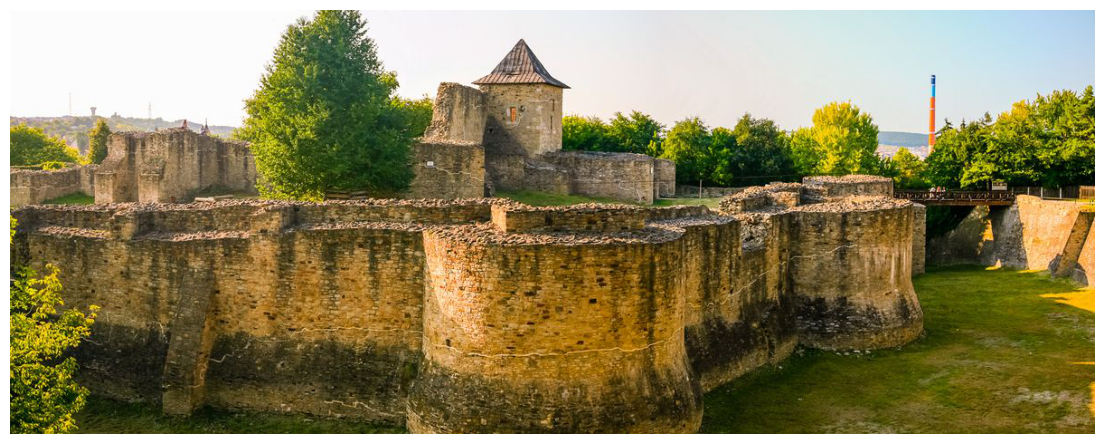

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('suceava.png')

plt.figure(figsize=(14, 30))
plt.axis('off')
plt.imshow(img)

In [ ]:
img.size

(1200, 469)

Să facem această poză cu cetatea Sucevei pătrată: o redimensionăm la 112x224 pixeli, apoi umplem restul pătratului cu 0 (negru).

In [ ]:
import torch
from torchvision import transforms

transform_img = transforms.Compose([
    transforms.Resize((112, 224)),
    transforms.Pad((0, 112 // 2))
])
new_img = transform_img(img)
new_img.size

(224, 224)

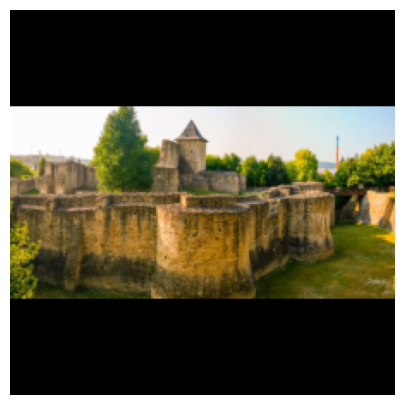

In [ ]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(new_img)

In [ ]:
transform_tensor = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

tensor_img = transform_tensor(new_img)
tensor_img.shape

torch.Size([3, 224, 224])

Deoarece imaginea este în format de culoare RGB, avem această formă. Pentru aplicarea straturilor convoluționale avem nevoie și de un set (lot) de poze, nu doar de 1 imagine. Pentru aceasta, vom adăuga o altă dimensiune torch cu `.unsqueeze(0)`.

In [ ]:
tensor_img = tensor_img.unsqueeze(axis=0)
tensor_img.shape

torch.Size([1, 3, 224, 224])

Luând în considerare dimensiunea de intrare de $(N, C_{in}, H_{in}, W_{in})$. După 1 convoluție vom obține un tensor cu forma $(N, C_{out}, H_{out}, W_{out})$.

Observați ceva suspect? Lățimea și înălțimea pozelor sunt modificate, într-adevăr, dar de ce și numărul de canale?

Intuiția din spatele acestui lucru, așa cum este descrisă [aici](https://datascience.stackexchange.com/questions/64278/what-is-a-channel-in-a-cnn):

„Canalele provin din „media”. Privind tehnologia de difuzare din spatele televizoarelor, aveți mai multe canale pentru diferite informații care sunt transmise la televizorul dvs. De exemplu, o imagine poate consta din doar trei canale care conțin informații despre cât de mult roșu, verde sau albastru fiecare pixelul dintr-o imagine este. Mapând acest lucru la un CNN, veți avea o imagine RGB cu trei canale. Totuși, o imagine poate fi interpretată și ca lucruri diferite. De exemplu, puteți prelua informații dintr-o imagine cât de cyan, magenta, galben sau negru ceva este. Aceasta ar însemna că imaginea dvs. CMYK va fi analizată de patru canale (fiecare culoare fiind un canal).

În CNN-urile, aceasta înseamnă că fiecare dintre filtrele dvs. este aplicat fiecărui canal. De ce? Pentru că s-ar putea ca filtrele dvs. să primească informații diferite de la fiecare dintre canale. Și poate că acestea converg către filtre diferite după fiecare pas de învățare.”

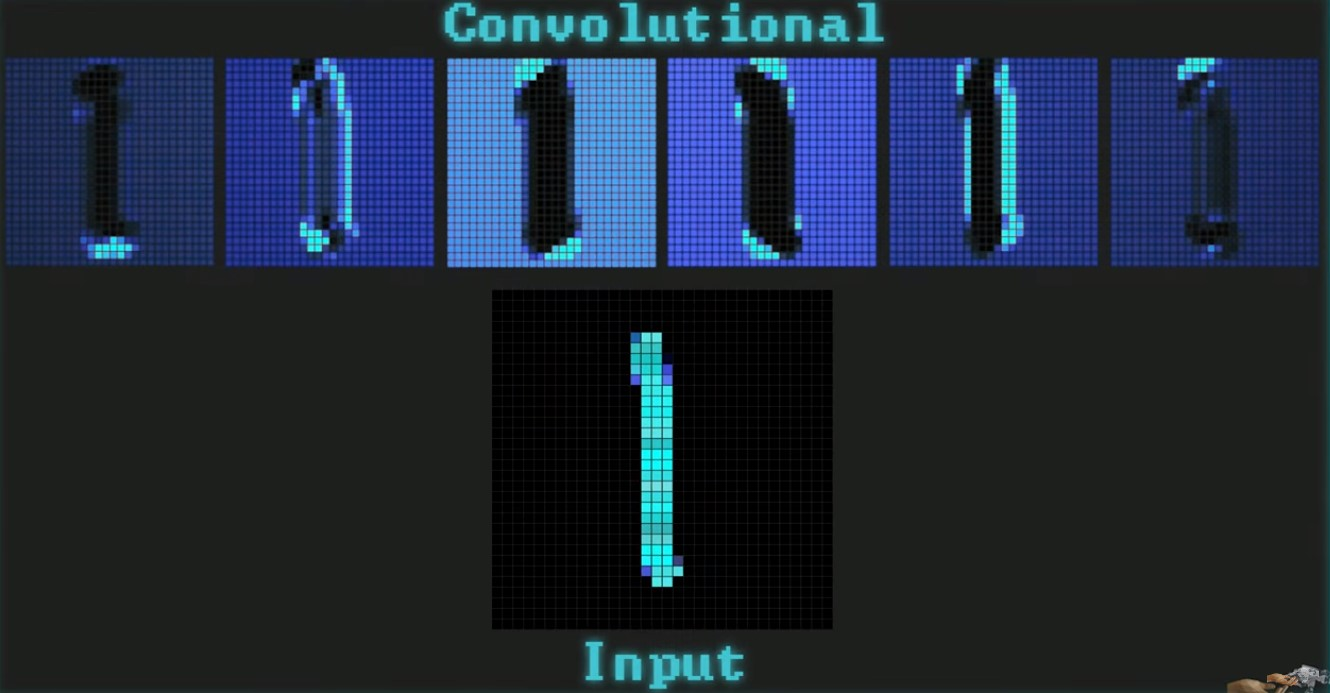

[torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- in_channels (int) – Numărul de canale din imaginea de intrare
- out_channels (int) – Numărul de canale produse de convoluție
- kernel_size (int or tuple) – Dimensiunea filtrului de convolutie
- stride (int or tuple, optional) – Pasul convolutiei. Default: 1
- padding (int, tuple or str, optional) – Dimensiunea ramei cu care se bordeaza imaginea de input. Default: 0
- padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' sau 'circular'. Default: 'zeros'
- dilation (int or tuple, optional) – Distanța dintre elementele filtrului de convolutie. Default: 1

Având acești parametri, formulele finale vor fi:

$$H_{out} = ⌊ \frac{H_{in} + 2 ̇\times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1)}{stride[0]} + 1⌋$$

$$W_{out} = ⌊ \frac{W_{in} + 2 ̇\times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1)}{stride[1]} + 1⌋$$

In [ ]:
import torch.nn as nn

convolution = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0, dilation=1)
convolved_img = convolution(tensor_img)
convolved_img.shape

torch.Size([1, 6, 222, 222])

Parametrii învățați sunt filtrele, stocate ca `.weight` și bias-ul, stocat ca `.bias`, care este un scalar pentru fiecare dintre canalele de ieșire.

In [ ]:
# (C_{out}, C_{in}, kernel\_size_[1], kernel\_size_[0])
print(convolution.weight.shape)

# (C_{out},)
print(convolution.bias.shape)

torch.Size([6, 3, 3, 3])
torch.Size([6])


## ReLU

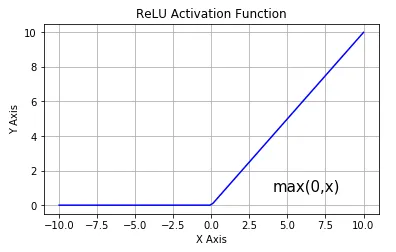

In [ ]:
activated_img = nn.ReLU()(convolved_img)
activated_img.shape

torch.Size([1, 6, 222, 222])

## Max Pooling

Max Pooling este o operație de agregare care calculează valoarea maximă pentru patch-uri ale unei hărți de caracteristici și o folosește pentru a crea o hartă de caracteristici subeșantionată (grupată). Se folosește de obicei după un strat convoluțional. Adaugă o cantitate mică de invarianță de traducere - adică traducerea imaginii cu o cantitate mică nu afectează în mod semnificativ valorile celor mai multe ieșiri grupate.

![imagine](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

[Parametrii](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) sunt similari cu convoluția. De asemenea, este important ca punerea în comun să se facă numai pe H și W, și nu pe canale. De asemenea, această operație nu folosește parametri care pot fi învățați. Exemplul de mai sus este un kernel_size = 2 (sau = (2, 2)), stride = 2, iar restul sunt în valorile implicite.

Input: $(N, C, H_{in}, W_{in})$   
Output: $(N, C, H_{out}, W_{out})$

The formula of $H_{out}$ and $W_{out}$ are the same with the convolution.

In [ ]:
max_pool = nn.MaxPool2d(kernel_size=2)
pooling_img = max_pool(activated_img)
pooling_img.shape

torch.Size([1, 6, 111, 111])

In [ ]:
def turn_channel_into_grayscale_img(tensor, channel_id):
    # repetarea canalului pentru a face un format RGB
    tensor_rgb = torch.cat(3 * [tensor[0, channel_id].unsqueeze(0)], axis=0)

    transform_inverse = transforms.ToPILImage()
    img = transform_inverse(tensor_rgb)
    return img

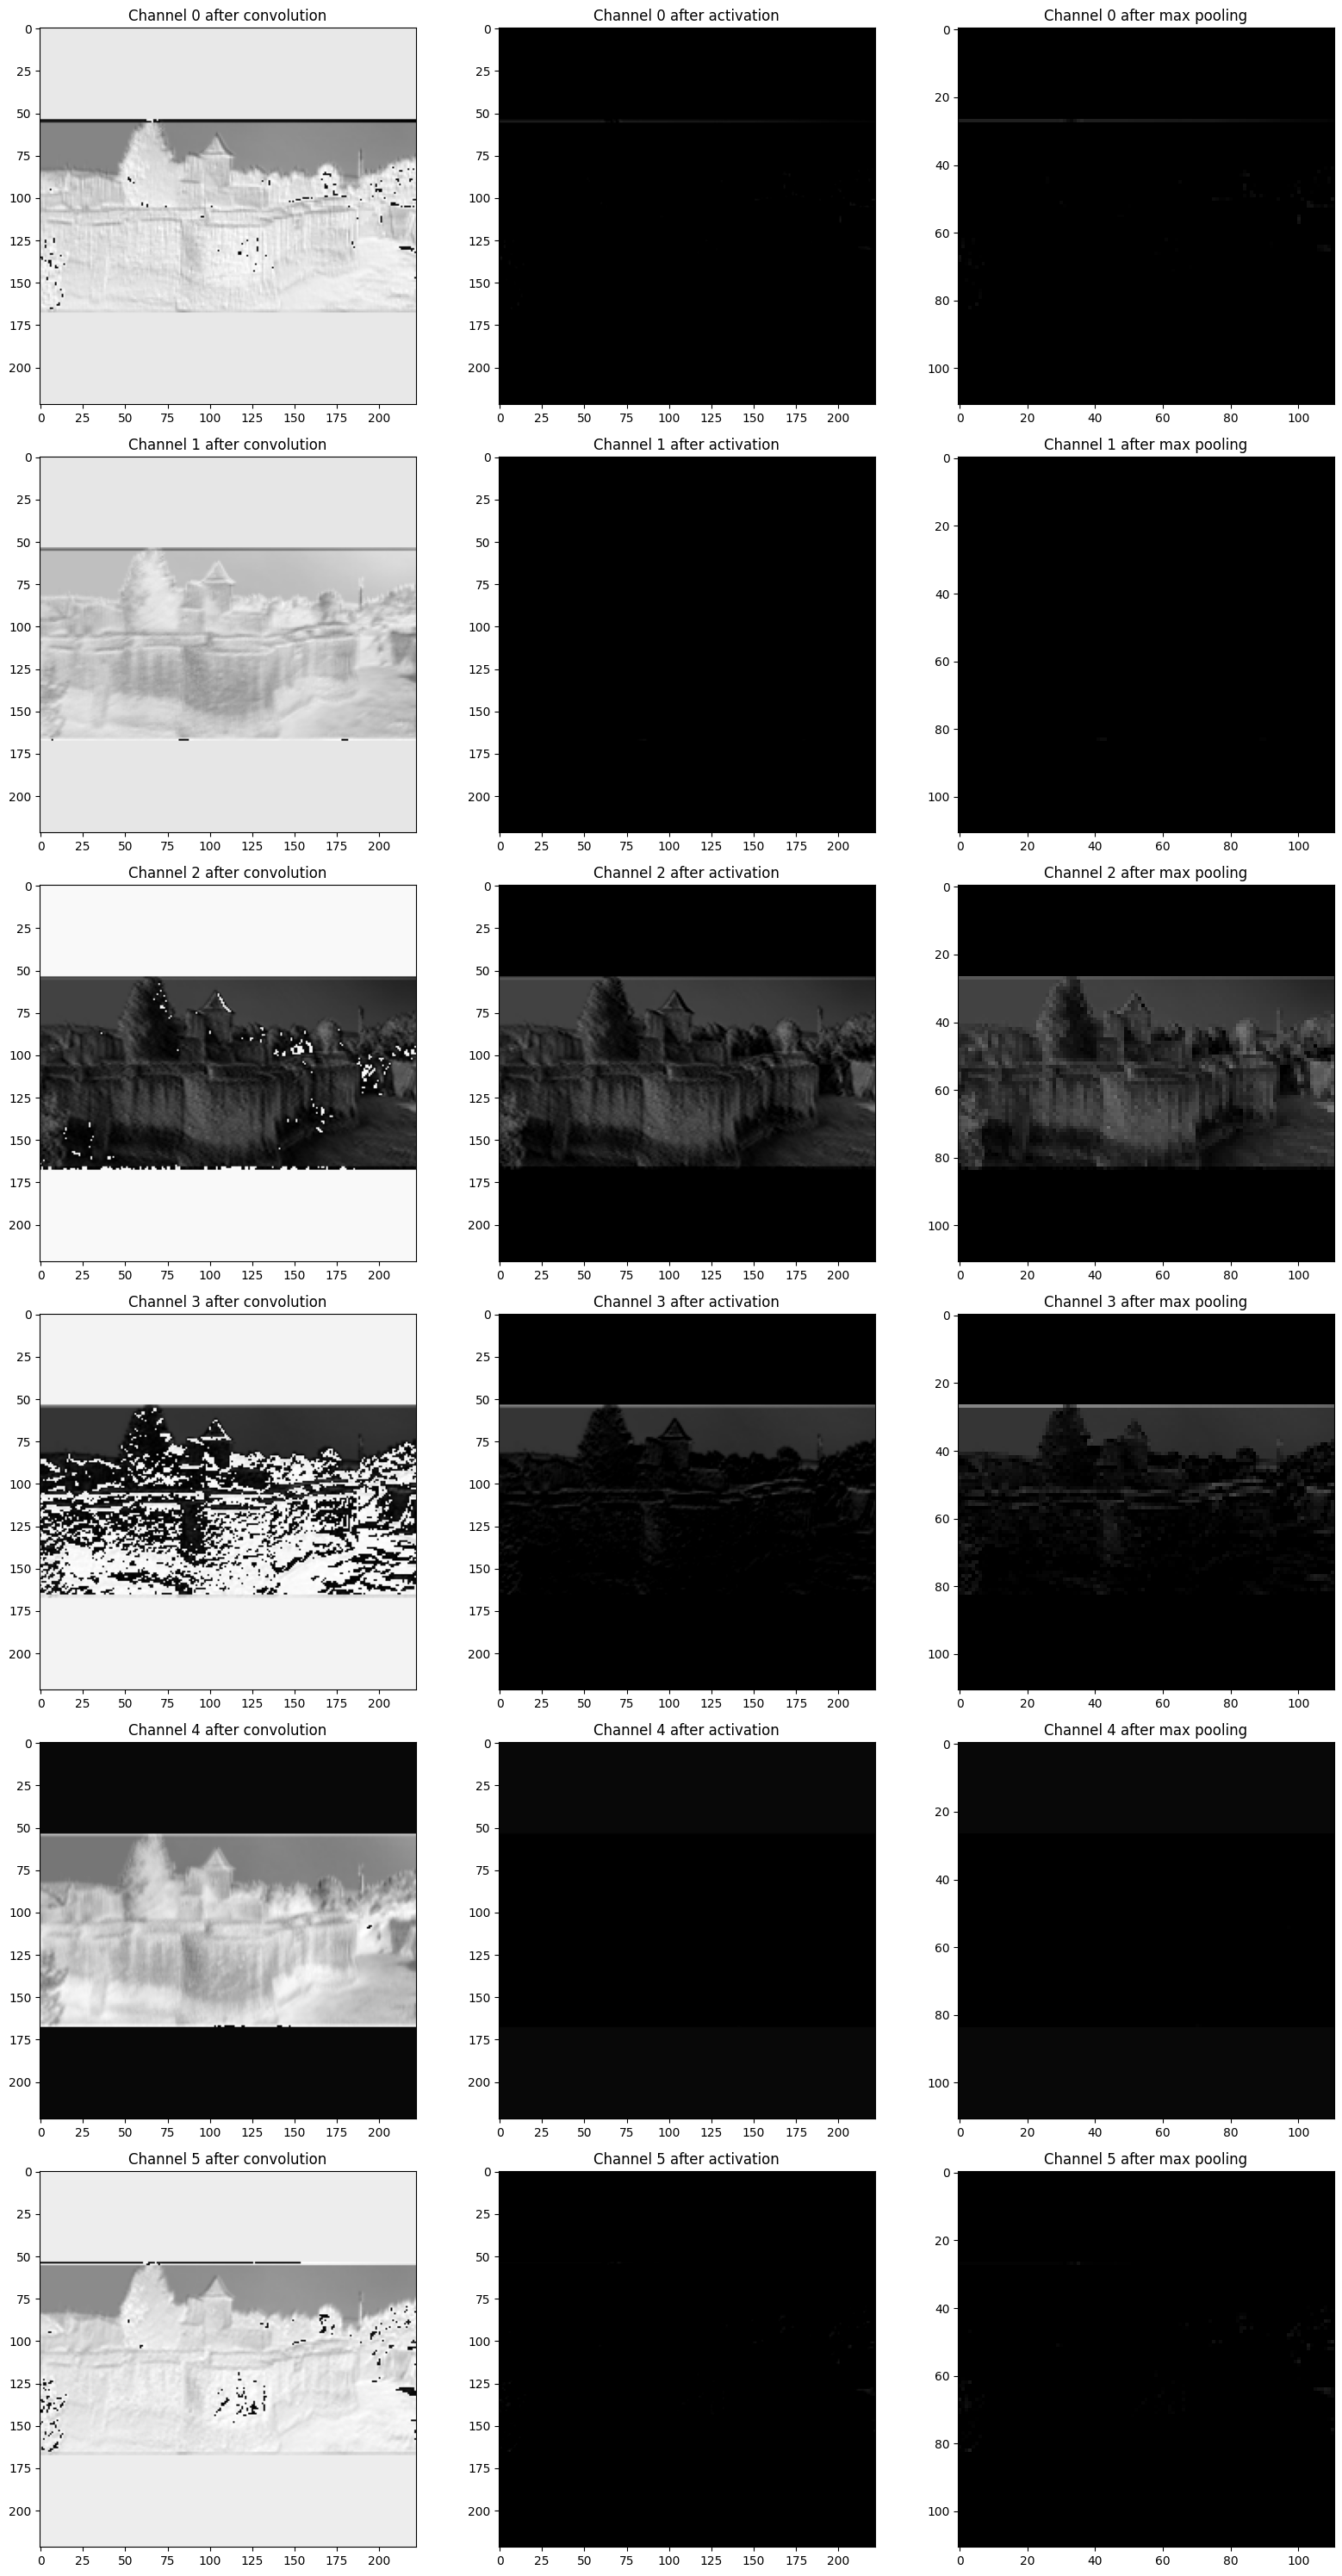

In [ ]:
figure, axes_matrix = plt.subplots(6, 3, figsize=(17, 30), tight_layout=True)

for channel_id, axes in enumerate(axes_matrix):
    conv_img = turn_channel_into_grayscale_img(convolved_img, channel_id)
    activ_img = turn_channel_into_grayscale_img(activated_img, channel_id)
    pool_img = turn_channel_into_grayscale_img(pooling_img, channel_id)

    axes[0].imshow(conv_img)
    axes[0].set_title(f"Channel {channel_id} after convolution")

    axes[1].imshow(activ_img)
    axes[1].set_title(f"Channel {channel_id} after activation")

    axes[2].imshow(pool_img)
    axes[2].set_title(f"Channel {channel_id} after max pooling")

Toate adunate intr-o rețea convoluțională, arată [astfel](https://poloclub.github.io/cnn-explainer/).

## CNNs pentru clasificarea textelor

Folosirea CNN-urilor pentru a clasifica textul a fost prima dată prezentată în: [Convolutional Neural Networks for Sentence Classification](https://aclanthology.org/D14-1181.pdf).

### Arhitectura CNN

<img src="https://richliao.github.io/images/YoonKim_ConvtextClassifier.png">

Dându-se ca input un text de $n$ cuvinte $w_{1}$, $w_{2}$, ..., $w_{n}$, transformăm fiecare cuvânt într-un vector de dimensiune $d$, rezultând vectorii $w_{1}$, $w_{2}$, ..., $w_{n}$ aparținând $R^d$. Matricea rezultată de dimensiune $d$×$n$ este apoi folosită ca input pentru un layer convoluțional care trece un *sliding window* peste text.

Pentru fiecare window de lungime $l$:

$u_{i}$ = [$w_{i}$, ..., $w_{i+l-1}$] $∈ R^{d×l}$, 0≤$i$≤$n-l$

Pentru fiecare filtru $f_{j} ∈ R^{d×l}$ calculăm <$u_{i}$, $f_{j}$> și obținem matricea $ F ∈ R^{m×n}$ (dacă am făcut padding înainte de aplicarea filtrului, astfel încât să păstrăm dimensiunea $n$ a cuvintelor), unde $m$ este numărul de filtre. Aplicăm max-pooling pe matricea $F$ rezultată, apoi aplicăm funcția de activare. În final, avem un layer *fully connected* care produce distribuția pe clase, din care rezultă clasa cu cea mai mare probabilitate.

### Convoluții și filtre

<img src="https://debajyotidatta.github.io/assets/images/conv.001.png" width="300">

**Inputul** este format dintr-o matrice de dimensiune $n$×$d$, unde $n$ este numărul de cuvinte sau caractere, iar $d$ este lungimea reprezentării vectoriale sau lungimea vocabularului.  

De exemplu, pentru reprezentarea vectorială a unui text la nivel de caracter, pentru $d$ = 70, numărul de caractere unice în vocabular, pe fiecare linie a matricei avem reprezentarea one-hot a unui caracter.

<img src="https://debajyotidatta.github.io/assets/images/conv.002.png" width="500">

**Filtrele** (kernels) pot avea orice lungime. Lungimea este dată de numărul de linii din filtru. Lățimea filtrului trebuie să fie aceeași cu numărul de coloane din reprezentarea vectorială ($d$).

<img src="https://debajyotidatta.github.io/assets/images/conv.003.png" width="300">

Operația de convoluție presupune multiplicarea elementelor din input și filtru, rezultând o valoare care reprezintă suma rezultatelor multiplicării. În consecință, operația de convoluție multiplică *weight*-urile din filtru cu reprezentarea vectorială a cuvintelor.

<img src="https://debajyotidatta.github.io/assets/images/conv.004.png" width="300">

<img src="https://debajyotidatta.github.io/assets/images/conv.005.png" width="300">

<img src="https://debajyotidatta.github.io/assets/images/conv.006.png" width="300">

Filtrul este aplicat secvențial peste input, dar, la fel ca în cazul imaginilor, putem folosi diferite valori pentru *stride* pentru a controla cât de mult de mișcă filtrul vertical. Utilizând *stride* cu o valoare $k$ putem aplica un filtrul din $k$ în $k$ linii. De exemplu, pentru un filtru cu stride = 2, filtrul va fi aplicat pe secvența de text din 2 în 2 linii și vom avea un output de dimensiune mai mică.

<img src="https://debajyotidatta.github.io/assets/images/conv2.006.png" width="450">

Filtre multiple vor produce output-uri multiple.

<img src="https://debajyotidatta.github.io/assets/images/conv2.007.png" width="450">

La următorul pas se realizează *max pooling* peste fiecare feature map rezultat din aplicarea filtrelor, iar apoi rezultatele sunt concatenate.

### Imagini vs Text

Pentru a înțelege de ce o abordare folosind CNN-uri este potrivită pentru text, trebuie să ne gândim la textele noastre ca fiind niște imagini.

Pentru exemplul următor vom cosidera că reprezentarea unei propoziții a fost făcută la nivel de cuvânt.

De exemplu, pentru o propoziție cu lungimea maximă de 70 de cuvinte și lungimea embeddingului egală cu 300, putem crea o matrice cu valori numerice de forma 70x300 pentru a reprezenta această propoziție. Spre deosebire de imagini, în care elementele matricei sunt reprezentate de valori ale pixelilor, fiecare linie din reprezentarea vectorială a propoziției este, de fapt, reprezentarea unui cuvânt.

În cazul imaginilor, filtrul de convoluție se deplasează și vertical și orizontal, dar în cazul textului, filtrul se deplasează doar vertical, convoluțiile sunt doar 1D. Un kernel de dimensiune (2, 300), care are dimensiunea filtrului egală cu 2 se uită doar la 2 cuvinte în același timp. Ne putem gândi, deci, la dimensionea filtrelor ca la o dimensiune a n-gramelor (bigrame, trigrame, etc.).

În acest laborator vom folosi datasetul IMDb movie reviews: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
! pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 23.3 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
from unidecode import unidecode
from collections import Counter
import nltk
from nltk import word_tokenize
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from urllib.request import urlretrieve
urlretrieve('https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv', 'IMDB_Dataset.csv')

('IMDB_Dataset.csv', <http.client.HTTPMessage at 0x7ff4423177f0>)

In [ ]:
data = pd.read_csv('IMDB_Dataset.csv')
data = data[:10000]
data

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0
...,...,...
9995,"The film maybe goes a little far, but if you l...",1
9996,This two-parter was excellent - the best since...,1
9997,Shaggy & Scooby-Doo Get a Clue. It's like watc...,0
9998,"Todd Rohal is a mad genius. ""Knuckleface Jones...",1


Impartim datasetul in train si test.

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.20, random_state = 42)

print('Dimensiunea datelor de train', len(train_df))
print('Dimensiunea datelor de test', len(test_df))

Dimensiunea datelor de train 8000
Dimensiunea datelor de test 2000


Așa cum am văzut în laboratoarele trecute, nu putem antrena un model direct pe datele sub formă de text, trebuie să transformam datele în reprezentări numerice vectoriale.

Pentru asta, trebuie să parcurgem 2 pași:

- **Tokenizare**: împărțirea textelor în subtexte mai mici. Astfel vom determina vocabularul setului nostru de date (setul de tokeni unici)

- **Vectorizare**: reprezentarea în format numeric vectorial

Textul poate fi reprezentat fie ca o secvență de caractere, fie ca o secvență de cuvinte. Utilizarea reprezentării la nivel de cuvânt are o performanță mai bună și este mai folosită, pe când reprezentarea la nivel de caracter este utilă dacă textele au multe greșeli de scriere.

### Reprezentarea vectorială la nivel de caracter


```
Texts: 'the mouse ran up the clock' and 'the mouse ran down'
```

Pe langa caracterele prezente in textele noastre, adaugam si 2 tokeni speciali: UNK (unknown) si PAD.


```
Index assigned for every token: {0: 'UNK', 1: 'PAD', 2: 't', 3: 'm', 4: 'c', 5: 'h', 6: 'l', 7: 'w', 8: ' ', 9: 'a', 10: 'k', 11: 'e', 12: 'r', 13: 'u', 14: 'n', 15: 's', 16: 'd', 17: 'p', 18: 'o'}
```

Reprezentarea vectoriala a celor doua texte folosind indexul corespunzator pentru fiecare caracter:

```
'the mouse ran up the clock' = [2, 5, 11, 8, 3, 18, 13, 15, 11, 8, 12, 9, 14, 8, 13, 17, 8, 2, 5, 11, 8, 4, 6, 18, 4, 10]
'the mouse ran down' = [2, 5, 11, 8, 3, 18, 13, 15, 11, 8, 12, 9, 14, 8, 16, 18, 7, 14]
```

Adaugam valori de padding la cel de-al doilea vector pentru a avea o lungime egala cu primul vector si obtinem:

```
[2, 5, 11, 8, 3, 18, 13, 15, 11, 8, 12, 9, 14, 8, 16, 18, 7, 14, 1, 1, 1, 1, 1, 1, 1, 1]
```

Transformăm lista de review-uri într-o listă de caractere pentru fiecare review.

In [ ]:
def transform_to_char(data):

    reviews = []

    for review in data:
        review_cleaned = [char.lower() for char in review]
        reviews.append(review_cleaned)

    return reviews

train_reviews = transform_to_char(train_df.review)
train_labels = train_df.sentiment.tolist()

print('Reviews', len(train_reviews))
print('Labels', len(train_labels))

Reviews 8000
Labels 8000


Calculam marimea vocabularului de caractere.

In [ ]:
def get_vocab(data):

    units = set([unit for review in data for unit in review])

    return units

vocab = get_vocab(train_reviews)

print('total chars:', len(vocab))
print(vocab)

total chars: 128
{'\x84', '=', 'å', '\x80', '6', ')', '^', 'r', '2', 'à', 'ú', '5', 'כ', '@', '\t', '~', 'ü', 'q', '”', 'ç', 'י', '\x91', '%', 'u', 'ý', 'h', 'ו', 'ë', '3', 'ל', "'", 'א', '’', 'ã', '*', 'á', '»', '[', 'â', 'ð', 'o', 'd', 'ן', '&', 'l', 'i', 'w', 'a', 'ï', ',', 'ö', 'æ', '\x95', '#', '\x85', 'ä', '³', 'ß', '_', 'õ', '«', '\\', '$', 'f', '7', '£', '9', 'ø', '\x96', 'ג', '(', 'g', 'î', 'z', '?', 'מ', 'v', 'n', 'ñ', ' ', '“', '½', 'p', '1', '}', '\xa0', '!', '>', 'k', 'é', '–', '¨', 'ר', '/', 'e', '´', 'x', 'í', ';', '+', 's', 'b', 'j', '8', 'ô', '‘', '"', '{', 'è', '.', 't', '4', '|', 'ó', '®', ']', 'ê', ':', '…', '\x97', '¢', 'c', 'y', '-', 'm', '`', '0', '<'}


Putem vedea ca avem foarte multe caractere cu accente, diferite de caracterele limbii engleze. Pentru a micsora lungimea vocabularului, putem transforma caracterele utf8 in cea mai apropiata forma ASCII a lor.

In [ ]:
reviews_to_ascii = [unidecode(review) for review in train_df.review]
train_reviews = transform_to_char(reviews_to_ascii)
vocab = get_vocab(train_reviews)

print('total chars:', len(vocab))
print(vocab)

total chars: 70
{'=', '\\', '$', 'f', '7', '9', ';', '+', 's', 'b', 'j', '6', '8', '*', '(', ')', '[', 'g', 'r', 'o', '"', '2', 'x', '^', 'd', '{', '.', '&', '5', 'l', 'i', 'z', '@', '\t', 't', 'w', '?', '4', '|', ']', '~', 'a', ':', 'v', 'n', ',', ' ', 'q', '#', 'p', '1', '}', 'c', 'y', '-', '%', 'u', '0', '!', '>', 'k', 'h', 'm', '`', '_', '3', '/', 'e', "'", '<'}


Atribuim fiecarui caracter din vocabularul nostru un index. Vom atribui 0 caracterelor necunoscute, iar 1 va fi valoarea atribuita paddingului.

In [ ]:
char_indices = dict((c, i + 2) for i, c in enumerate(vocab))
indices_char = dict((i + 2, c) for i, c in enumerate(vocab))

indices_char[0] = 'UNK'
char_indices['UNK'] = 0

indices_char[1] = 'PAD'
char_indices['PAD'] = 1

print('Dimensiunea vocabularului', len(indices_char))
print(indices_char)

Dimensiunea vocabularului 72
{2: '=', 3: '\\', 4: '$', 5: 'f', 6: '7', 7: '9', 8: ';', 9: '+', 10: 's', 11: 'b', 12: 'j', 13: '6', 14: '8', 15: '*', 16: '(', 17: ')', 18: '[', 19: 'g', 20: 'r', 21: 'o', 22: '"', 23: '2', 24: 'x', 25: '^', 26: 'd', 27: '{', 28: '.', 29: '&', 30: '5', 31: 'l', 32: 'i', 33: 'z', 34: '@', 35: '\t', 36: 't', 37: 'w', 38: '?', 39: '4', 40: '|', 41: ']', 42: '~', 43: 'a', 44: ':', 45: 'v', 46: 'n', 47: ',', 48: ' ', 49: 'q', 50: '#', 51: 'p', 52: '1', 53: '}', 54: 'c', 55: 'y', 56: '-', 57: '%', 58: 'u', 59: '0', 60: '!', 61: '>', 62: 'k', 63: 'h', 64: 'm', 65: '`', 66: '_', 67: '3', 68: '/', 69: 'e', 70: "'", 71: '<', 0: 'UNK', 1: 'PAD'}


Acum putem transforma propozitiile din datasetul nostru intr-o reprezentare vectoriala, in care vom avea pentru fiecare caracter indicele corespunzator din vocabularul nostru.

In [ ]:
import numpy as np

def vectorize_sentences(data, char_indices, one_hot = False):
    vectorized = []
    for sentences in data:

        # transformam fiecare review in reprezentarea lui sub forma de indici ale caracterelor continute
        sentences_of_indices = [char_indices[w] if w in char_indices.keys() else char_indices['UNK'] for w in sentences]

        # pentru fiecare indice putem face reprezentarea one-hot corespunzatoare
        # sau putem sa nu facem asta si sa adaugam un embedding layer in model care face această transformare
        if one_hot:
            sentences_of_indices = np.eye(len(char_indices))[sentences_of_indices]

        vectorized.append(sentences_of_indices)

    return vectorized

train_reviews_vectorized = vectorize_sentences(train_reviews, char_indices)
# train_reviews_vectorized[0]

In [ ]:
train_reviews_vectorized[0][:100]

In [ ]:
vectors_dim = [len(repr) for repr in train_reviews_vectorized]
vectors_dim[:5]

[1957, 370, 903, 3001, 1403]

Putem vedea ca deoarece review-urile au numar diferit de caractere, in consecinta, si dimensiunile reprezentarilor vectoriale sunt diferite.
Vom aduce reprezentarile noastre la aceeasi dimensiune maxima.

Definim o functie *pad* care:

- primeste un set de review-uri si o lungime maxima
- scurteaza toate reprezentarile mai mari decat lungimea maxima
- adauga valoarea de padding (1 in cazul nostru) la reprezentarile mai scurte decat lungimea maxima

In [ ]:
def pad(samples, max_length):

    return torch.tensor([
        sample[:max_length] + [1] * max(0, max_length - len(sample))
        for sample in samples
    ])

Mai departe trunchem toți vectorii la 1000.

In [ ]:
train_reviews_vectorized = pad(train_reviews_vectorized, max_length = 1000)
train_reviews_vectorized

tensor([[32, 36, 48,  ..., 58, 10, 36],
        [26, 32, 26,  ...,  1,  1,  1],
        [36, 63, 32,  ...,  1,  1,  1],
        ...,
        [32, 48, 31,  ...,  1,  1,  1],
        [26, 69, 10,  ...,  1,  1,  1],
        [36, 63, 32,  ...,  1,  1,  1]])

Avem 8000 de review-uri și fiecare review are dimensiunea 1000.

In [ ]:
train_reviews_vectorized.shape

torch.Size([8000, 1000])

Tranformăm și review-urile din setul de test într-o reprezentare vectorială

In [ ]:
test_reviews_to_ascii = [unidecode(review) for review in test_df.review]
test_reviews = transform_to_char(test_reviews_to_ascii)
test_labels = test_df.sentiment.tolist()

print('Reviews', len(test_reviews))
print('Labels', len(test_labels))

Reviews 2000
Labels 2000


In [ ]:
test_reviews_vectorized = vectorize_sentences(test_reviews, char_indices)
test_reviews_vectorized = pad(test_reviews_vectorized, max_length = 1000)
# test_reviews_vectorized[0]

Vom încărca seturile noastre de date într-un obiect din clasa [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset).

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __getitem__(self, k):
        """Returneaza al k-lea exemplu din dataset"""
        return self.samples[k], self.labels[k]

    def __len__(self):
        """Returneaza dimensiunea datasetului"""
        return len(self.samples)

Definim arhitectura modelului

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Definim un embedding layer cu un vocabular de dimensiune 72
        # și ca output un embedding de dimensiune 20
        # padding_idx este indexul din vocabular al paddingului (1, în cazul nostru)

        self.embedding = torch.nn.Embedding(72, 20, padding_idx=1)

        # Definim o secvență de layere

        # Un layer Convolutional 1D cu 20 input channels, 32 output channels, dimensiune kernel = 3 și padding = 1
        # ReLU activation
        # 1D Maxpooling layer de dimensiune 2
        conv1 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=20, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )

        # Un layer Convolutional 1D cu 32 input channels, 32 output channels, dimensiune kernel = 5 și padding = 2
        # ReLU activation
        # 1D Maxpooling layer de dimensiune 2
        conv2 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )

        # Global Average pooling layer care, în cazul nostru, este un 1D Avgerage Pooling layer
        # cu dimensiunea de 250 și stride 250
        global_average = torch.nn.AvgPool1d(kernel_size=250, stride=250)

        self.convolutions = torch.nn.Sequential(
            conv1, conv2, global_average
        )

        # Flattening layer
        flatten = torch.nn.Flatten()

        # Linear layer cu 32 input features și 2 outputs fără funcție de activare
        linear = torch.nn.Linear(in_features=32, out_features=2)

        self.classifier = torch.nn.Sequential(flatten, linear)

    def forward(self, input):
        # trecem inputul prin layerul de embedding
        embeddings = self.embedding(input)

        # permutăm inputul astfel încât prima dimensiune este numărul de channels
        embeddings = embeddings.permute(0, 2, 1)

        # trecem inputul prin secvența de layere
        output = self.convolutions(embeddings)
        output = self.classifier(output)
        return output


In [ ]:
DEVICE = torch.device("cuda")
# instanțiem modelul
model = Model().to(DEVICE)

# Adam optimizer cu lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Cross Entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

# training dataset and dataloader
# test dataset and dataloader
train_ds = Dataset(train_reviews_vectorized, train_labels)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_ds = Dataset(test_reviews_vectorized, test_labels)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

Training loop

In [ ]:
best_val_acc = 0
for epoch_n in range(10):
    print(f"Epoch #{epoch_n + 1}")
    model.train()
    for batch in train_dl:
        model.zero_grad()

        inputs, targets = batch
        inputs = inputs.long().to(DEVICE)
        targets = targets.to(DEVICE)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()

    # validare
    model.eval()
    all_predictions = torch.tensor([])
    all_targets = torch.tensor([])
    for batch in test_dl:
        inputs, targets = batch
        inputs = inputs.long().to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.no_grad():
            output = model(inputs)

        predictions = output.argmax(1)
        all_targets = torch.cat([all_targets, targets.detach().cpu()])
        all_predictions = torch.cat([all_predictions, predictions.detach().cpu()])

    val_acc = (all_predictions == all_targets).float().mean().numpy()
    print(val_acc)

    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "./model")
        best_val_acc = val_acc

print("Best validation accuracy", best_val_acc)

Epoch #1
0.51
Epoch #2
0.51
Epoch #3
0.517
Epoch #4
0.547
Epoch #5
0.6565
Epoch #6
0.669
Epoch #7
0.659
Epoch #8
0.693
Epoch #9
0.7025
Epoch #10
0.704
Best validation accuracy 0.704


### Reprezentarea vectoriala la nivel de cuvant



```
Texts: 'The mouse ran up the clock' and 'The mouse ran down'
```

Pe langa tokenii prezenti in textele noastre, adaugam si 2 tokeni speciali: UNK (unknown word) si PAD.


```
Index assigned for every token: {'UNK': 0, 'PAD': 1, 'the': 2, 'mouse': 3, 'ran': 4, 'up': 5, 'clock': 6, 'down': 7}
```

Reprezentarea vectoriala a celor doua texte folosind indexul corespunzator pentru fiecare cuvant:

```
'The mouse ran up the clock' = [2, 3, 4, 5, 2, 6]
'The mouse ran down' = [2, 3, 4, 7]
```

Adaugam valori de padding la cel de-al doilea vector pentru a avea o lungime egala cu primul vector si obtinem:

```
[2, 3, 4, 7, 1, 1]
```
Reprezentarea one-hot a fiecarui text:

```
'The mouse ran up the clock' = [[0. 0. 1. 0. 0. 0. 0.]
                                [0. 0. 0. 1. 0. 0. 0.]
                                [0. 0. 0. 0. 1. 0. 0.]
                                [0. 0. 0. 0. 0. 1. 0.]
                                [0. 0. 1. 0. 0. 0. 0.]
                                [0. 0. 0. 0. 0. 0. 1.]]

'The mouse ran down' = [[0. 0. 1. 0. 0. 0. 0. 0.]
                        [0. 0. 0. 1. 0. 0. 0. 0.]
                        [0. 0. 0. 0. 1. 0. 0. 0.]
                        [0. 0. 0. 0. 0. 0. 0. 1.]
                        [0. 1. 0. 0. 0. 0. 0. 0.]]
```

Impartim textele din dataset in tokeni.

In [ ]:
def transform_to_tokens(data):

    reviews = []
    for review in data:
        review_tokenized = word_tokenize(review.lower())
        reviews.append(review_tokenized)

    return reviews

In [ ]:
train_reviews = transform_to_tokens(train_df.review)
for r in train_reviews[:2]:
    print(r[:20])

['it', 'is', 'interesting', 'to', 'see', 'what', 'people', 'think', 'of', 'this', 'movie', ',', 'since', 'it', 'is', ',', 'in', 'fact', ',', 'quite']
['did', 'the', 'first', 'travesty', 'actually', 'make', 'money', '?', 'this', 'is', 'another', 'sequel', '(', 'along', 'the', 'lines', 'of', 'another', 'stakeout', ')']


Construim vocabularul de tokeni

In [ ]:
vocab = get_vocab(train_reviews)

print('total words:', len(vocab))
print(list(vocab)[:100])

total words: 64266
['dr.tadokoro', 'jibes', 'ooooohhhh', 'advertised', 'willam', 'isolationist', 'redd', 'five-hundred-million', 'horsing', 'absurdest', 'gifts.', 'practitioner', 'tackles', 'turtlenecks', 'malta', '-screened', 'movie/theatre', 'drank', 'weaned', 'explicit', 'alluring.', 'renewal', 'cronenbergs', 'perplexity', 'sensibilities.', 'heck-of-a', 'shearer', 'received-', 'tastes', 'gurning', 'giardello', 'body-dissolving', 'dvd.', 'rewrote', 'bos', 'sharpen', 'picerni', 'context.', 'crushes', 'grand-mal', 'meet.so', 'ooooo', 'thriller.', 'barter', 'odder', 'raciest', 'amounted', 'no-talent', '3.99', 'elo', 'oppenheimer.', 'havegotten', 'trashes', 'hasidic', 'soup', 'inter', 'pappy', 'friel', 'missing.', 'reviewers', 'parole', 'c-', 'accentuated', 'doormen', 'pfieffer', 'riverbank.', 'piggy', 'brigite', 'flynn/gable', 'dilo', 'nationality', 'unfunniness', 'acting-directing', 'strong-willed', 'good/bad', 'almost-parallels', 'minnesota', 'fully-realized', 'me', 'muzaffer', 'stage

Avem un vocabular foarte mare. Vom scoate din vocabular cuvintele cu o frecventa foarte mica.

O alta abordare pentru micscorarea vocabularului este scoaterea cuvintelor foarte frecvente (stopwords). De asemenea putem face si alti pasi de preprocesare: putem face stemming, lematizare, putem scoate punctuatia, etc.)

In [ ]:
import operator

def word_freq(data, min_aparitions):

    all_words = [words.lower() for sentences in data for words in sentences]
    sorted_vocab = sorted(dict(Counter(all_words)).items(), key=operator.itemgetter(1))
    final_vocab = [k for k,v in sorted_vocab if v > min_aparitions]

    return final_vocab

In [ ]:
vocab = word_freq(train_reviews, min_aparitions = 10)

print(vocab[:100])
print(len(vocab))

['toll', 'denying', 'reported', 'shaft', 'histrionics', 'questioned', 'hurting', 'deliverance', 'backwoods', 'translate', 'dreadfully', 'bump', 'caper', 'sophomoric', 'hypnotic', 'washed', 'playful', 'stream', 'baddie', 'humiliating', 'necessity', 'incompetence', 'amidst', 'exposes', 'sirk', 'marc', 'interspersed', 'paste', 'grieving', 'tightly', 'masked', 'boil', 'marvin', 'cliffhanger', 'airing', 'video.', 'hilarious.', 'schneider', 'covert', 'holland', 'somber', 'salvage', 'sydow', 'towering', 'cannibalism', 'knives', 'shepard', 'remainder', 'two-dimensional', 'virtues', 'adapting', 'incidental', "'it", '..i', 'sites', 'observed', 'exploiting', 'ploy', 'czech', 'conflicted', 'stares', 'chiller', 'monument', 'raj', 'progressively', 'jox', 'tournament', 'stir', 'atop', 'shelter', 'backing', 'dives', 'dangers', 'unleashed', 'atomic', 'build-up', 'b-grade', 'garland', 'hamming', 'steele', 'orchestral', 'switched', 'opponent', 'cunning', 'chef', 'lottery', 'sumptuous', 'potent', 'spinnin

Fiecarui token ii atribuim un indice.

In [ ]:
word_indices = dict((c, i + 2) for i, c in enumerate(vocab))
indices_word = dict((i + 2, c) for i, c in enumerate(vocab))

indices_word[0] = 'UNK'
word_indices['UNK'] = 0

indices_word[1] = 'PAD'
word_indices['PAD'] = 1

In [ ]:
# print(indices_word)

Acum putem transforma propozitiile din datasetul nostru intr-o reprezentare vectoriala, in care vom avea pentru fiecare cuvant indicele corespunzator din vocabular.

In [ ]:
train_reviews_vectorized = vectorize_sentences(train_reviews, word_indices)

In [ ]:
vectors_dim = [len(repr) for repr in train_reviews_vectorized]
vectors_dim[:5]

[423, 77, 186, 580, 288]

Din nou, pentru ca textele au un numar diferit de cuvinte, trebuie sa aducem vectorii la o reprezentare de aceeași dimensiune.

In [ ]:
train_reviews_vectorized = pad(train_reviews_vectorized, max_length = 512)
train_reviews_vectorized

tensor([[9707, 9712, 9486,  ...,    1,    1,    1],
        [9635, 9719, 9619,  ...,    1,    1,    1],
        [9704, 9697, 9712,  ...,    1,    1,    1],
        ...,
        [9705, 9301, 9719,  ...,    1,    1,    1],
        [9261, 9719,  251,  ...,    1,    1,    1],
        [9704, 9712, 9567,  ...,    1,    1,    1]])

In [ ]:
train_reviews_vectorized.shape

torch.Size([8000, 512])

# EXERCIȚII

Folosind datasetul întreg de mai sus (IMDb reviews) implementati urmatoarele cerinte:
1. Impartiti setul de date in 80% train, 10% validare si 10% test
2. Tokenizati textele si determinati vocabularul (in acest task vom lucra cu reprezentari la nivel de cuvant, NU la nivel de caracter); intrucat vocabularul poate fi foarte mare, incercati sa aplicati una dintre tehnicile mentionate in laborator (10K-20K de cuvinte ar fi o dimensiunea rezonabila a vocabularului)
3. Transformati textele in vectori de aceeasi dimensiune folosind indexul vocabularului (alegeti o dimensiune maxima de circa 500-1000 de tokens)
4. Implementati urmatoarea arhitectura:
    * un Embedding layer pentru vocabularul determinat, ce contine vectori de dimensiune 100
    * un layer dropout cu probabilitate 0.4
    * un layer convolutional 1D cu 100 canale de input si 128 de canale de output, dimensiunea kernelului de 3 si padding 1; asupra rezultatului aplicati un layer de [BatchNormalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) cu 128 features; aplicati apoi functia de activare ReLU, iar in cele din urma un strat de max-pooling 1D cu kernel size 2.
    * un layer convolutional 1D cu 128 canale de input si 128 de canale de output, dimensiunea kernelului de 5 si padding 2; asupra rezultatului aplicati un layer de BatchNormalization cu 128 features; aplicati apoi functia de activare ReLU, iar in cele din urma un strat de max-pooling 1D cu kernel size 2.
    * un layer convolutional 1D cu 128 canale de input si 128 de canale de output, dimensiunea kernelului de 5 si padding 2; asupra rezultatului aplicati un layer de BatchNormalization cu 128 features; aplicati apoi functia de activare ReLU, iar in cele din urma un strat de max-pooling 1D cu kernel size 2.
    * asupra rezultatului ultimului layer, aplicati average-pooling 1D obtinand pentru fiecare canal media tuturor valorilor din vectorul sau corespunzator
    * un layer feed-forward (linear) cu dimensiunea inputului 128, si 2 noduri pentru output (pentru clasificare in 0/1)
5. Antrenati arhitectura folosind cross-entropy ca functie de loss si un optimizer la alegere. La finalul fiecarei epoci evaluati modelul pe datele de validare si salvati weighturile celui mai bun model astfel determinat
6. Evaluati cel mai bun model obtinut pe datele de test.
